Read time series dataset and load each column as an array
Time-->t
Magnitude-->Y
Error-->e

In [358]:
import numpy as np
from numpy import *

# Load data
ts = np.loadtxt('w.dat', unpack = True)
#print(ts)
# Time(t) and magnitude(Y) and error(e)
t = ts[0]
Y = ts[1]
e = ts[2]
# Mean value, maximum value, minimum value of magnitude
v0 = np.mean(Y)
v_max = np.max(Y)
v_min = np.min(Y)
# max and min difference 
v_diff = v_max - v_min
# Average value of error
e_avg = np.mean(abs(e))
print(e_avg)
print(max(e))
print(min(e))

0.004310750909692359
0.0087
0.0032


In [359]:
import matplotlib.pyplot as plt

# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# Simulation parameters(T is time period, N is number of points, dt is time interval)
T = t[-1] - t[0]
N = len(t)
dt = T/N
# List of time points
t_bm = np.arange(t[0], t[-1], dt)

Create Brownian motion

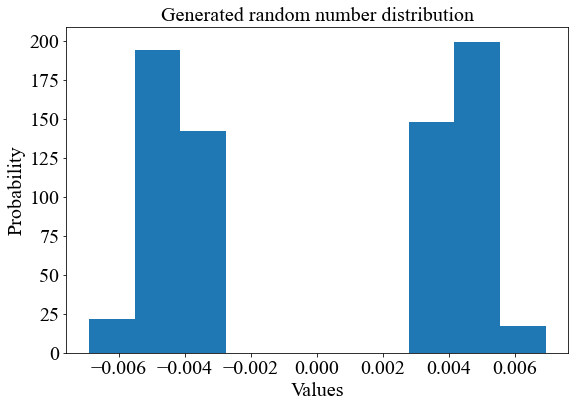

In [360]:
import scipy.stats as stats

# Generate random number 
lower, upper = 0.003, 0.009
mu, sigma = 0.004310750909692359, 0.0007671127621733211
# rdm represents normal distribution with x limitation
rdm = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
dB = rdm.rvs(N)
dB_n = []
for item in dB:
    new = item *random.choice((1,-1))
    dB_n.append(new) 
    
plt.hist(dB_n, density=True)
plt.xlabel('Values', size=20, family='Times New Roman')
plt.ylabel('Probability', size=20, family='Times New Roman')
plt.title('Generated random number distribution', size=20, family='Times New Roman')
plt.xticks(family='Times New Roman', fontsize=20)
plt.yticks(family='Times New Roman', fontsize=20)
plt.show()

Keep sigma = e_avg, amp = 0.016, find most fitted model parameter

In [361]:
import math
import random

sigma = e_avg
amp = 0.016
# Setting the sample of omega dataset in range of [140,160]s
omega_begin = (2 * math.pi) / (150./3600./24.)
omega_end = (2 * math.pi) / (130./3600./24.)
omega_sample = np.linspace(omega_begin, omega_end, 10)
# Setting the sample of phi dataset in range of [0，2*pi/omega]
phi_begin = 0
phi_end = (2*math.pi)/omega_begin
phi_sample = np.linspace(phi_begin, phi_end, 100)

# Using list to record parameters in a combination following a sequence seperately
omega_record = []
phi_record = []
# Loop for implementing every trial
# kai_sample is a list of calculated kai square value
kai_sample = []
for omega in omega_sample:
    for phi in phi_sample:
        # EM Approximatiom
        # y_bm_0 is magnitude of assumed initial point
        y_bm_0 = v0
        # Define y_em as calculated value
        y_em = []
        # Define a intial point value for SDE approximation
        X = y_bm_0
        for j in range(N):
            X +=  amp * omega * math.cos(omega*t_bm[j] + phi) * dt + sigma*X*dB_n[j]
            y_em.append(X)

        # Loop for calculate sum of differences square(v_obs_j - v_cal_j)^2 of observed value and calculated value for each point
        for i in range(N):
            # terms = [] is a list of elements for calculating kai-squre
            terms = []
            d = Y[i] - y_em[i]
            terms.append((d**2 / e[i]**2))
        # Calculate kai for each trial
        kai = math.sqrt(np.sum(terms))
        # Collect sample kai**2
        kai_sample.append(kai)
                
        # Collect sample parameters value in pair as one point in kai distribution plot
        omega_record.append(omega)
        phi_record.append(phi)

# print(kai_sample)
# Find the minimum value and index of kai in the list
kai_min = min(kai_sample)
index_kai_min = kai_sample.index(kai_min)

# Find corresponding value of parameters according to minimum value of kai
omega_fit = omega_record[index_kai_min]
phi_fit = phi_record[index_kai_min]

print("Size of kai_sample is:", len(kai_sample))
print("The minimum value is:", kai_min)
print("Corresponding parameter value is:")
print(omega_fit)
print(phi_fit)
print("Fitted omega value is:", (2*math.pi) / (omega_fit/3600./24.))

Size of kai_sample is: 1000
The minimum value is: 0.6048882649868482
Corresponding parameter value is:
4175.901619540895
0.001736111111111111
Fitted omega value is: 130.0


Visualize kai_sample

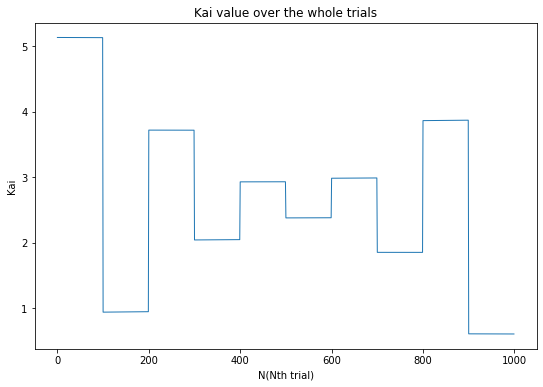

In [362]:
x = np.arange(0, 1000, 1)
# print(x)
plt.title('Kai value over the whole trials')
plt.ylabel('Kai')
plt.xlabel('N(Nth trial)')
plt.plot(x, kai_sample)

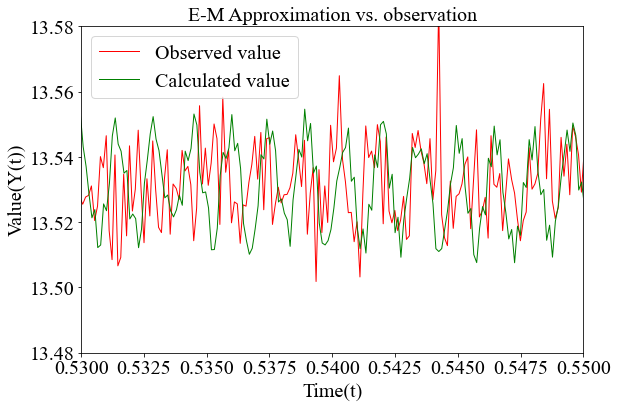

In [363]:
# Fitted value of omega and Phi
omega = omega_fit
phi = phi_fit

# EM Approximatiom
# Define y_em as approximate value
y_em = []
# Define a intial point value for SDE approximation
X = y_bm_0
for j in range(N):
    X +=  amp * omega * math.cos(omega*t_bm[j] + phi) * dt + sigma*X*dB_n[j]
    y_em.append(X+dB_n[j])

# setting x-axis(time)
plt.xlim(0.53, 0.55)
plt.ylim(13.48, 13.58)

# plot fitted approximation and observed value for comparison
plt.xticks(family='Times New Roman', fontsize=20)
plt.yticks(family='Times New Roman', fontsize=20)
font1 = {"family" : "Times New Roman", "size" : 20}
plt.title('E-M Approximation vs. observation', size=20, family='Times New Roman')
plt.ylabel('Value(Y(t))', size=20, family='Times New Roman')
plt.xlabel('Time(t)', size=20, family='Times New Roman')
plt.plot(t, Y, label = "Observed value", color = 'red')
plt.plot(t_bm, y_em, label="Calculated value", color='green')
plt.legend(loc = 2, prop=font1)